# Monte-Carlo Network Entropy simulation

In [1]:
import numpy as np
import random
import helper_functions as hf
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Simulate Network

In this section a simple quantum network will be simulated many times, once the qubits have been sent through the network they will be measured in various measurement bases, this information will be used to construct the density matrix representing the network. 

In [50]:
# All length-2 Pauli strings as lists of two basis labels (for simulate_network)
paulis = ['i','x', 'y', 'z']
measurement_bases = [ [a, b] for a, b in itertools.product(paulis, repeat=2) ]

# A variable to store the expected values for each measurement basis
expected_values=[]
uncertainties=[]

iterations=1_000
stateA = np.array([[1], [0]])
stateB = np.array([[1], [0]])
for basis in measurement_bases:
    basis_expected_value = 0
    for i in range(iterations):
        basis_expected_value += hf.simulate_network([stateA, stateB],errors=[[0, 0, 0], [0, 0, 0], [0.2, 0.2, 0.2]],
                                                    measurement_bases=basis)
    expected_values.append(basis_expected_value/iterations)

    # Calculate the uncertainty of each expected value
    mean = basis_expected_value / iterations
    uncertainty = np.sqrt((1 - mean**2) / iterations)
    uncertainties.append(float(uncertainty))

# Calculate 99% confidence intervals for each expected value
confidence_intervals = []
z_score = 2.576  # for 99% confidence interval (two-sided normal distribution)

for mean, uncertainty in zip(expected_values, uncertainties):
    lower = mean - z_score * uncertainty
    upper = mean + z_score * uncertainty
    confidence_intervals.append((lower, upper))



print("Expected values for each measurement basis:", expected_values)
print("Uncertainties for each expected value:", uncertainties)

print("99% confidence intervals for each expected value:", confidence_intervals)

Expected values for each measurement basis: [1.0, 0.024, -0.01, 0.316, 0.074, 0.026, -0.018, 0.046, 0.016, -0.008, 0.006, 0.012, 1.0, -0.022, 0.008, 0.35]
Uncertainties for each expected value: [0.0, 0.03161366793018488, 0.03162119542332326, 0.03000239990400768, 0.031536074581342555, 0.031612086296225375, 0.03161765329685301, 0.03158930198659034, 0.031618728627191825, 0.03162176465664116, 0.03162220738658198, 0.031620499679796334, 0.0, 0.031615122963543886, 0.03162176465664116, 0.02962262648719725]
99% confidence intervals for each expected value: [(1.0, 1.0), (-0.057436808588156245, 0.10543680858815624), (-0.09145619941048072, 0.07145619941048073), (0.23871381784727622, 0.3932861821527238), (-0.007236928121538422, 0.15523692812153841), (-0.055432734299076566, 0.10743273429907656), (-0.09944707489269336, 0.06344707489269336), (-0.03537404191745672, 0.12737404191745672), (-0.06544984494364614, 0.09744984494364614), (-0.08945766575550765, 0.07345766575550763), (-0.07545880622783518, 0.08

## Reconstruct Density Matrix

In [47]:
pauli_dict = {
        'i': np.eye(2),
        'x': np.array([[0, 1], [1, 0]]),
        'y': np.array([[0, -1j], [1j, 0]]),
        'z': np.array([[1, 0], [0, -1]])
    }

# Reconstruct the density matrix
density_matrix = np.zeros((4, 4), dtype=complex)




for i, basis in enumerate(measurement_bases):
    expected_value = expected_values[i]
    pauli_matrix = np.kron(pauli_dict[basis[0]], pauli_dict[basis[1]])
    density_matrix += (expected_value) * pauli_matrix

density_matrix /= 2**(2) # Normalize the density matrix
#density_matrix = np.round(density_matrix, decimals=5)  # Round for better readability
print("Reconstructed Density Matrix:")
print(density_matrix)

Reconstructed Density Matrix:
[[ 0.67585+0.j      0.0027 +0.0066j -0.0018 +0.0011j -0.0016 -0.0004j]
 [ 0.0027 -0.0066j  0.32415+0.j     -0.0028 -0.0044j  0.0034 +0.0039j]
 [-0.0018 -0.0011j -0.0028 +0.0044j  0.00135+0.j      0.0046 +0.0007j]
 [-0.0016 +0.0004j  0.0034 -0.0039j  0.0046 -0.0007j -0.00135+0.j    ]]


### Reconstruct Density Matrix Confidence Interval

In [27]:
z_score = 2.576  # 99% confidence

density_matrix_uncertainty = np.zeros_like(density_matrix, dtype=float)

for i in range(4):
    for j in range(4):
        var = 0.0
        for k, basis in enumerate(measurement_bases):
            pauli_matrix = np.kron(pauli_dict[basis[0]], pauli_dict[basis[1]])
            var += (uncertainties[k] ** 2) * np.abs(pauli_matrix[i, j]) ** 2
        density_matrix_uncertainty[i, j] = np.sqrt(var) / 4  # divide by 4 for normalization

# Now calculate confidence intervals for each element
density_matrix_CI = []
for i in range(4):
    row = []
    for j in range(4):
        lower = density_matrix[i, j] - z_score * density_matrix_uncertainty[i, j]
        upper = density_matrix[i, j] + z_score * density_matrix_uncertainty[i, j]
        row.append((lower, upper))
    density_matrix_CI.append(row)

print("99% confidence intervals for each density matrix element:")
for i in range(4):
    for j in range(4):
        print(f"rho[{i},{j}]: {density_matrix_CI[i][j]}")

99% confidence intervals for each density matrix element:
rho[0,0]: (np.complex128(1+0j), np.complex128(1+0j))
rho[0,1]: (np.complex128(-0.007577892788426529-0.0055j), np.complex128(0.01817789278842653-0.0055j))
rho[0,2]: (np.complex128(-0.012729403706596979+0.0006000000000000003j), np.complex128(0.013029403706596977+0.0006000000000000003j))
rho[0,3]: (np.complex128(-0.018779221122849937-0.0019j), np.complex128(0.006979221122849938-0.0019j))
rho[1,0]: (np.complex128(-0.007577892788426529+0.0055j), np.complex128(0.01817789278842653+0.0055j))
rho[1,1]: (np.complex128(0j), np.complex128(0j))
rho[1,2]: (np.complex128(-0.017079221122849937+0.0021j), np.complex128(0.00867922112284994+0.0021j))
rho[1,3]: (np.complex128(-0.009929403706596979-0.0060999999999999995j), np.complex128(0.015829403706596978-0.0060999999999999995j))
rho[2,0]: (np.complex128(-0.012729403706596979-0.0006000000000000003j), np.complex128(0.013029403706596977-0.0006000000000000003j))
rho[2,1]: (np.complex128(-0.01707922112

### Visualize density matrix

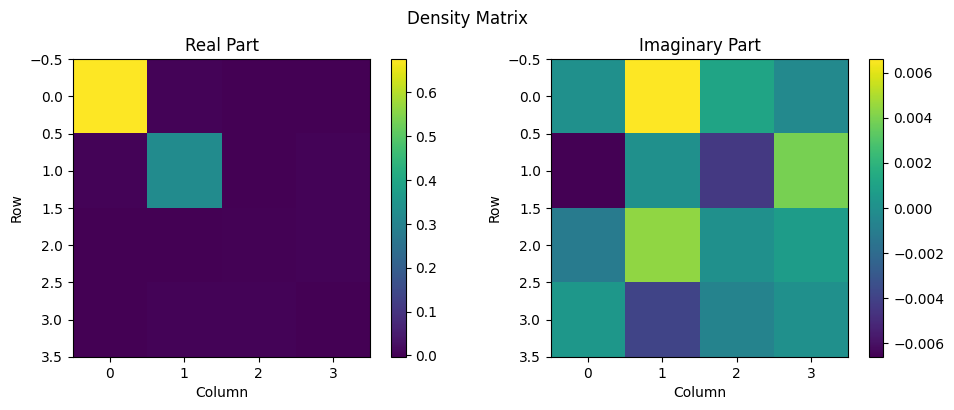

In [49]:
def plot_density_matrix(rho, title="Density Matrix"):
    """
    Visualizes the real and imaginary parts of a density matrix using matplotlib.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axes[0].imshow(rho.real, cmap='viridis', interpolation='nearest')
    axes[0].set_title('Real Part')
    plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(rho.imag, cmap='viridis', interpolation='nearest')
    axes[1].set_title('Imaginary Part')
    plt.colorbar(im1, ax=axes[1])
    for ax in axes:
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage (after you have computed 'density_matrix'):
plot_density_matrix(density_matrix)

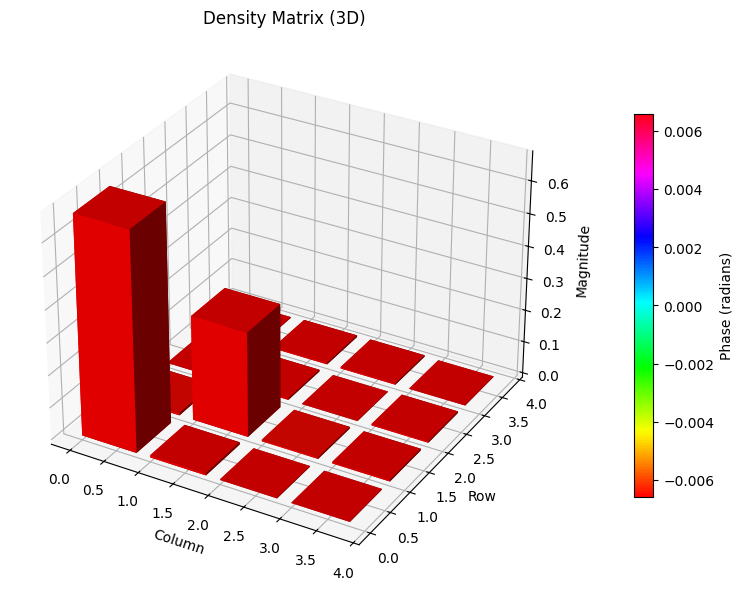

In [48]:
def plot_density_matrix_3d(rho, title="Density Matrix (3D)"):
    """
    3D visualization of a density matrix.
    Height = magnitude (abs), color = phase (angle of complex number).
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    n = rho.shape[0]
    xpos, ypos = np.meshgrid(np.arange(n), np.arange(n), indexing='ij')
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like(xpos)

    # Heights are the magnitude of each element
    dz = np.abs(rho.flatten())

    # Color is the phase (angle) mapped to HSV
    complex = np.imag(rho.flatten())
    colors = plt.cm.hsv((complex))

    ax.bar3d(xpos, ypos, zpos, 0.8, 0.8, dz, color=colors, shade=True)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_zlabel('Magnitude')
    ax.set_title(title)

    # Add a colorbar for phase
    mappable = plt.cm.ScalarMappable(cmap='hsv')
    mappable.set_array(complex)
    cbar = plt.colorbar(mappable, ax=ax, pad=0.1, shrink=0.7)
    cbar.set_label('Phase (radians)')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_density_matrix_3d(density_matrix)